In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
from matplotlib import rcParams
from module import *




plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})    


π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_m = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr
t_eq = 1.59246e12/yr      # in units of seconds

k = 22.5707
σ_eq = 0.005
ρ_m = 4e19                #ρ_m = 4e19 M☉ Gpc^-3


m_1 = 7   #in units of M☉
m_2 = 9   #in units of M☉

y_1 = math.log(m_1)
y_2 = math.log(m_2)
dy = (y_2-y_1)


y_list = np.zeros(11)

for i in range(len(y_list)):
    y_list[i] = (y_1 + (i*dy))
    

M_1_list = np.zeros(len(y_list))
M_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    M_1_list[i] = (math.ceil(math.exp(y)))
    M_2_list[i] = (math.ceil(math.exp(y)))
    

            
m_1_list = [int(M_1) for M_1 in M_1_list]
m_2_list = [int(M_2) for M_2 in M_2_list]

    
Δ_1_list = np.zeros(len(y_list))
Δ_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    Δ_1_list[i] = math.exp(y + 0.5*dy)-math.exp(y - 0.5*dy)
    Δ_2_list[i] = math.exp(y + 0.5*dy)-math.exp(y - 0.5*dy) 
        

In [6]:
def merger_rate(m_1,m_2,Δ_1,Δ_2,λ_0,t_m):
    
    A=((ρ_eq**(4/3))*(G**3)*(k**7))/(c**5)

    
    def s(λ_0): # S_dec of the binary decouple.
        return ((0.03095*λ_0 + 0.3425)*λ_0)
    
    def t(λ_0): 
        return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(λ_0)-2)*np.sqrt(s(λ_0)+1))+(4/3)))
    
    def a_i_by_x(λ_0):
        return (0.0977* λ_0 + 0.0057 * (λ_0**2))

    def ρ_bar(m):
        return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 
    
    def M_halo(m,λ_0):
        return (((16*π)/3)*ρ_bar(m)*((2*G*m*(t(λ_0)**2))**(1/4)))
    
    def M(m,λ_0):
        return (m + M_halo(m,λ_0))
    
    def M_binary_initial(m_1,m_2, λ_0):
        return (m_1 + m_2 + M_halo(m_1,λ_0) + M_halo(m_2,λ_0))
      
    def f_(m):
        return f*P(m)
    
    def f_b(m_1,m_2):
        return  f_(m_1)+f_(m_2)
    
    
    #Schwarzchild Radius of the PBH.
    def r_s(m): 
        return ((2*G*m)/(c**2)) 


    #r_turnaround of the dark matter halos, eq.(5) in "WIMPs and stellar-mass primordial black holes are incompatible"
    def r_ta(m,λ_0): 
        return ((2*G*m*(t(λ_0)**2))**(1/3))


    # The binding energy, E_b of the dark matter halos calculated within r_s and r_ta for dark matter halo's density profile of ρ(r)∝ r^{-9/4}
    def E_b(m,s): 
        return ((16*π*G*ρ_bar(m)*m*(((r_ta(m,λ_0))**(-1/4))-((r_s(m))**(-1/4))))-((128/3)*G*(π**2)*(ρ_bar(m)**2)*(((r_ta(m,λ_0))**(1/2))-((r_s(m))**(1/2)))))
    
    def x(m_1,m_2,λ_0):
        return ((3 * (m_1 + m_2)* λ_0 ) /(8 * π * ρ_eq))**(1/3)
    
    def a_initial(m_1,m_2,λ_0):
        return a_i_by_x(λ_0) * x(m_1,m_2,λ_0)

    def beta(m_1,m_2,λ_0 ):
        return ((G*m_1*m_2)/((G*M(m_1,λ_0)*M(m_2,λ_0))-(2*a_initial(m_1,m_2,λ_0)*(E_b(m_1,λ_0)+E_b(m_2,λ_0)))))

    
     
    def B(m_1,m_2,Δ_1,Δ_2):
        return (A**(1/7)) * ((m_1 * m_2 * t_m)**(1/7)) *   (M_binary_initial(m_1,m_2, λ_0)**(1/2)) *  ((m_1+m_2)**(-23/42)) * ((f_b(m_1,m_2))**(37/21))* ((f**2 + 1.2005*(σ_eq**2))**(-1/2)) * ((Δ_1*Δ_2)**(37/42)) * (beta(m_1,m_2,λ_0)**(-1/14))
    
    
    def D(m_1,m_2,Δ_1,Δ_2):
        return (B(m_1,m_2,Δ_1,Δ_2)**(21/37))/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2))  
    
    
    def γ_X(Y,m_1,m_2,Δ_1,Δ_2):      #eq.(12) in the notes.
        return ((((1 + 0.0583 * D(m_1,m_2,Δ_1,Δ_2) * (Y**(-21/37)))**(-1/14))/( 1 + 0.4440 * D(m_1,m_2,Δ_1,Δ_2) * (Y**(-21/37))))*Y)

    
    def PDF(m):
        return (P(m)/m)

    
    I = quad(PDF, 5, np.inf)  # Taking limits of the PBH mass from 5 M☉ to 100 M☉ instead of 
                               # 0 to infinity.
    
    n_T = f * ρ_eq * I[0]         #n_T=f*ρ_eq∫(P(m)/m)*dm 
   
    
    def x̄(m_1,m_2,Δ_1,Δ_2):
        return (((3*(m_1+m_2))/(8*π*ρ_eq*f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2)))**(1/3))
    
    
    Y=np.geomspace(1e-2,1e10*pc,1000000) 
    
    
    def integrand(Y,m_1,m_2,Δ_1,Δ_2):
        return (Y**(-58/37))   *  np.exp(-((4*π)/3)  * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T * ((Y/B(m_1,m_2,Δ_1,Δ_2))**(-21/37))) * ((γ_X(Y,m_1,m_2,Δ_1,Δ_2)**2)/ ((1 + (γ_X(Y,m_1,m_2,Δ_1,Δ_2)**2))**(3/2)))
    
   
    return (3/74) * (A**(3/37))  * ρ_m  * (t_m ** (-34/37))* (f**2) *  ((f**2 + 1.2005*(σ_eq**2))**(-21/74)) *  ((m_1 * m_2)**(3/37)) * (M_binary_initial(m_1,m_2,λ_0)**(21/74)) *  ((m_1+m_2)**(51/74))* (beta(m_1,m_2,λ_0)**(-3/74)) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2)  * (np.trapz(integrand(Y,m_1,m_2,Δ_1,Δ_2),Y)) 


In [8]:
# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


Merge_halo = np.zeros((11, 11))



for i in range(11):
    for j in range(11):
        
        f_pbh = 4.3e-3
        f = 0.85 * f_pbh
        
          
        def P(m): #Powerlaw PBH mass distribution
            α = 1.6
            M = 5     #in units of M☉
            return ((α-1)/M) * ((m/M)**(-α))

        if i==j:
            Merge_halo[i,j] = 0.5*merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], 4, t_m)
            
        else:
            Merge_halo[i,j] = merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], 4, t_m)   
    
        
np.save("Merge_halo", Merge_halo)



In [9]:
# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


Merger_halo = np.zeros((11, 11))


for i in range(11):
    for j in range(11):
        
        f_pbh = 3.7e-3
        f = 0.85*f_pbh 
        
        def P(m):               #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉
            return  (1/(σ * m * math.sqrt(2*π))) * math.exp(-((math.log(m/m_c))**2)/(2*(σ**2)))

        if i==j:
            Merger_halo[i, j] = 0.5 * merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], 4, t_m)
            
        else:
            Merger_halo[i, j] = merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], 4, t_m)
            

np.save("Merger_halo", Merger_halo)

In [7]:
file1 = np.load('Merge_halo.npy')
Merge_nohalo = file1


file2 = np.load('Merger_halo.npy')
Merger_nohalo = file2



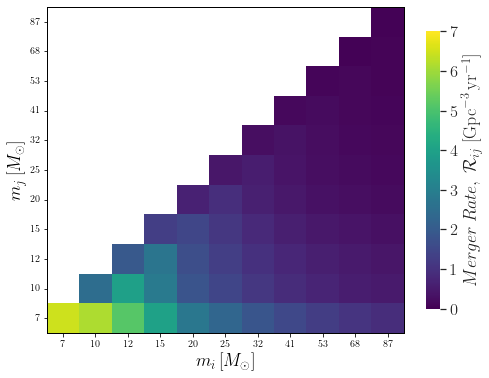

In [10]:
# Plot of merger rate for Power Law PBH mass function.

mask = np.tril(Merge_halo, k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize=(8, 6)) 

sns.set(font_scale=1.5)

ax = sns.heatmap(Merge_halo, mask = mask,  cmap = 'viridis', cbar = True, 
                 cbar_kws = {"shrink": 0.85,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 vmin = 0,vmax = 7)


# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'

ax.set_xticklabels(m_1_list)
ax.set_yticklabels(m_2_list,rotation = 360)


ax.invert_yaxis()
plt.xlabel('$m_{i}\,[M_{\odot}]$', fontsize = 18)
plt.ylabel('$m_{j}\,[M_{\odot}]$', fontsize = 18)
plt.savefig('PWRLawDM.pdf')
plt.show()    

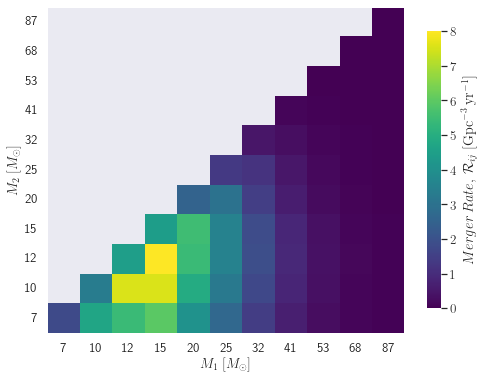

In [11]:
# Plot of Merger rate for Log-Normal PBH mass function.



mask = np.tril(Merger_halo, k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize = (8, 6))  


sns.set(font_scale=1.2)  


ax = sns.heatmap(Merger_halo, mask = mask,  cmap = 'viridis', cbar = True,
                 cbar_kws = {"shrink": 0.85, 'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 vmin = 0, vmax=8)


ax.set_xticklabels(m_1_list, fontsize=13)
ax.set_yticklabels(m_2_list,rotation = 360, fontsize=13)


# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)


    
ax.invert_yaxis()
plt.xlabel('$M_{1}\: [M_{\odot}]$', fontsize=14)
plt.ylabel('$M_{2}\: [M_{\odot}]$', fontsize=14)
plt.savefig(' LOGNORMALwithDM.pdf')
plt.show()  